In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from datasets import load_mnist

bs = 100
train_loader, test_loader, val_loader = load_mnist(bs)

In [ ]:
import pytorch_lightning as pl

from models.lin_vae import LinearVAE

class LinearVAETrainer(pl.LightningModule):
    def __init__(self, hidden_dims = [512, 256], latent_dim = 2):
        super(LinearVAETrainer, self).__init__()
        
        self.model = LinearVAE(hidden_dims, latent_dim)
        
    def forward(self, x, x_cond):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, mu, log_var = self(x, x_cond)
        loss = self.model.loss(x, x_hat, mu, log_var)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True)
        return loss['loss']
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-3)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='vae-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

model = LinearVAETrainer()
trainer = pl.Trainer(accelerator='gpu', devices=[5], max_epochs=50, enable_progress_bar=True, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/linear_vae_50.ckpt')

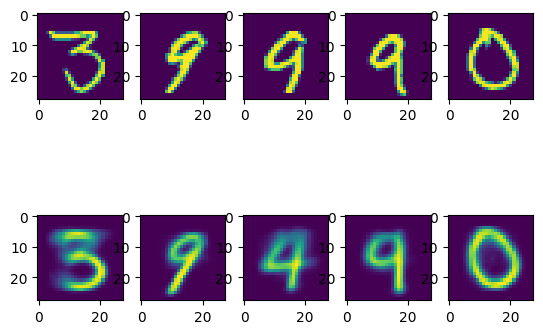

In [4]:
model = LinearVAETrainer.load_from_checkpoint('checkpoints/linear_vae_50.ckpt')
model.eval().cuda(device = 5)

from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstruction


plot_samples_with_reconstruction(model, next(iter(test_loader)))
